# This file contains an analysis of the effect of Obstructive Sleep Apnea on endothelial function.

In [1]:
options(warn=-1)
homedir <- "C:/Users/breng/Desktop/final miR210 analysis"
funcsfile <- "miR210_functions.r"
funcsfilepy <- "python_motif_annotation.py"
Organ <- "Homo sapiens" 
BioMartdataset <-"hsapiens_gene_ensembl"
# datasets
miRNAseq <- "./data/miRNA_chypoxia_data/GSE116909_Supplemental_Tab._2.csv"
combinedDT <- "./data/3 ucsd_xian_taiwan.xls"
osaseq <- "./data/19 OSA RNAseq raw merge genes.xls"          
# libraries
suppressMessages({
    library(stringi)
    library(data.table)
    library(ggplot2)
    library(ggpubr)
    library(MyPackage)
    library(reticulate)
    library(purrr)
    library(dplyr)
    # propensity score matching
    library(Matching)
    # correaltion analysis
    library(Hmisc)
    library(corrplot)
    # motif analysis
    library(biomaRt)
    library(seqinr)
    library(rtracklayer)
    library(GenomicRanges)
    library(ConservationtextmineR)
    library(Biostrings)
    library(seqLogo)
    library(BCRANK)
    library(JASPAR)
    # RNAseq
    library(systemPipeR);
    library(ShortRead)
    library(ConservationtextmineR)
    library(RColorBrewer)
    library(pheatmap)
    library(GenomicFeatures)
    library(BiocParallel)
    # KEGG pathway analysis
    library(pathview)
    library(gage)
    library(IRdisplay)
})
setwd(homedir)
source(funcsfile)
source_python(funcsfilepy)
namestr = list(
  condition = c("normal","mild","moderate","severe","unknown"),
  location = c("UCSD","taiwan","xian"))
#slugdt <- data.table(v1=c(1,2,3),v2=c("a","b","c"))
#str(slugdt)
#newcols <- c("v3","v4","v5")
#for (n in newcols) slugdt[[n]] <- as.numeric(NA)
#slugdt
#library(stringi) 
#slugstr <- "a'b:c d" 
#slugstr <- stri_replace_all_fixed(slugstr, pattern = c("'", ":", " "), replacement = c(""), vectorize_all = FALSE)
#slugstr
#str(slugdt)
#slugdt
#slugdt[v2=="b",.(v1,v2)]
#slugdt[v2=="b",v1]

## Analysis of miRNAseq data

In [2]:
dt <- fread(miRNAseq)
dt <- dt[,c(1, 2, 4, 6, 3, 5, 7)][(dt$`Chronic hypoxia 3 h 12 min` > 0 & dt$`Chronic hypoxia 8 h` > 0 & dt$`Chronic hypoxia 14 h 24 min` > 0 &
                                  dt$`Cyclic hypoxia Cycle 2` > 0 & dt$`Cyclic hypoxia Cycle 5` > 0 & dt$`Cyclic hypoxia Cycle 9` > 0) |
                                  (dt$`Chronic hypoxia 3 h 12 min` < 0 & dt$`Chronic hypoxia 8 h` < 0 & dt$`Chronic hypoxia 14 h 24 min` < 0 &
                                  dt$`Cyclic hypoxia Cycle 2` < 0 & dt$`Cyclic hypoxia Cycle 5` < 0 & dt$`Cyclic hypoxia Cycle 9` < 0),]
bothup <-intersect(dt[dt$`Chronic hypoxia 3 h 12 min` < dt$`Chronic hypoxia 8 h` & dt$`Chronic hypoxia 8 h` < dt$`Chronic hypoxia 14 h 24 min`,]$`miRNA name`,
                   dt[dt$`Cyclic hypoxia Cycle 2` < dt$`Cyclic hypoxia Cycle 5` & dt$`Cyclic hypoxia Cycle 5` < dt$`Cyclic hypoxia Cycle 9`,]$`miRNA name`)

str(dt)

Classes 'data.table' and 'data.frame':	81 obs. of  7 variables:
 $ miRNA name                 : chr  "hsa-let-7c-3p" "hsa-miR-100-3p" "hsa-miR-1264" "hsa-miR-1284" ...
 $ Chronic hypoxia 3 h 12 min : num  -1.1 -1.68 -3.34 -1.23 -1.35 -2.22 1.02 -1.22 -1.66 -2.09 ...
 $ Chronic hypoxia 8 h        : num  -1.6 -1.87 -1.93 -1.47 -1.93 -1.65 1.11 -2.01 -2.12 -1.8 ...
 $ Chronic hypoxia 14 h 24 min: num  -2 -2.42 -2.26 -1.97 -2.62 -2.15 1.12 -1.97 -2.86 -1.96 ...
 $ Cyclic hypoxia Cycle 2     : num  -1.73 -1.37 -2.1 -1.45 -1.15 -1.72 1.8 -1.98 -1.29 -1.34 ...
 $ Cyclic hypoxia Cycle 5     : num  -2.01 -1.45 -1.37 -2.14 -1.12 -1.42 2.18 -2.05 -1.67 -1.2 ...
 $ Cyclic hypoxia Cycle 9     : num  -1.68 -1.16 -1.78 -1.81 -1.1 -2 2.2 -1.8 -1.3 -1.53 ...
 - attr(*, ".internal.selfref")=<externalptr> 


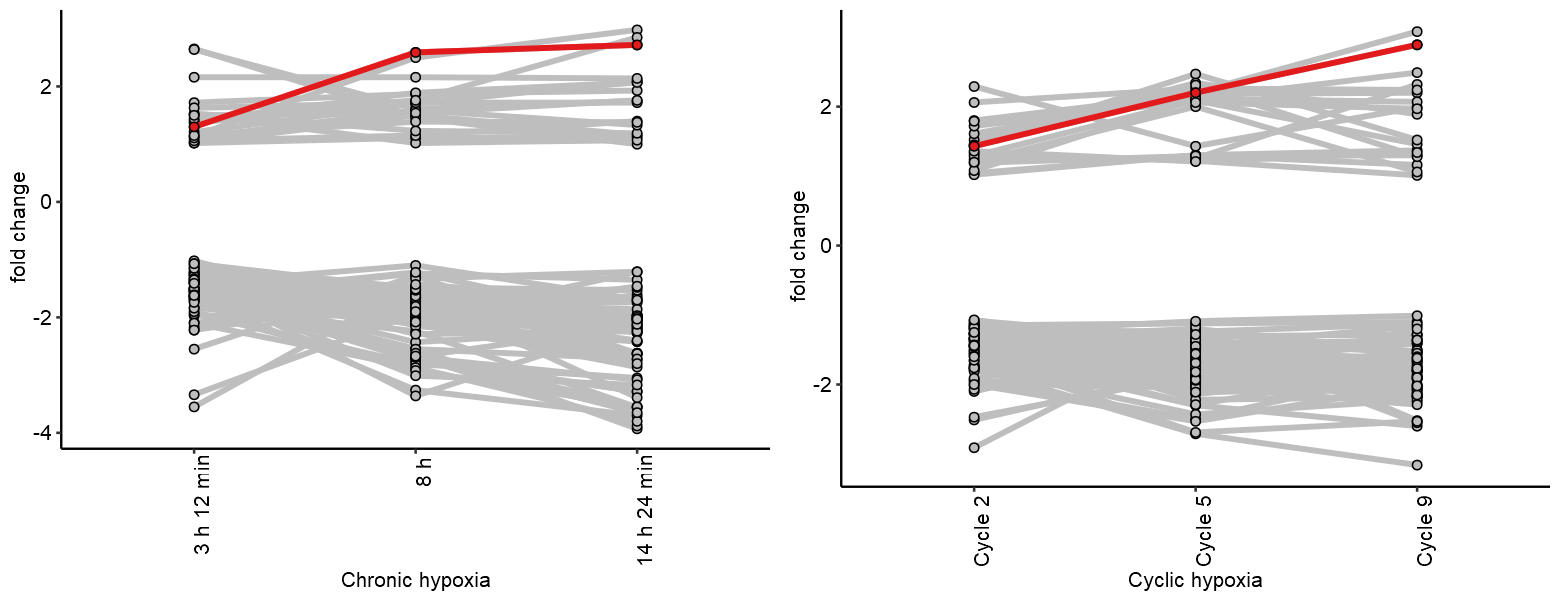

In [3]:
options(repr.plot.width=13, repr.plot.height=5)
mel <- melt(dt, id = 1)
mel$status <- "NA"
mel[(mel$`miRNA name` %in% bothup),]$status <- "trend"
mel[!(mel$`miRNA name` %in% bothup),]$status <- "no_trend"
mel$variable <- stri_replace_all_fixed(mel$variable, pattern = c("Chronic hypoxia ", "Cyclic hypoxia "), 
                                       replacement = c(""), vectorize_all = FALSE)
mel$variable <- factor(mel$variable, levels= c("3 h 12 min", "8 h", "14 h 24 min", "Cycle 2", "Cycle 5", "Cycle 9"),
                       labels = c("3 h 12 min", "8 h", "14 h 24 min", "Cycle 2", "Cycle 5", "Cycle 9"))

p1 <- ggplot(data=mel, aes(x=variable, y=value, group=`miRNA name`))+
  theme_pubr()+
  geom_line(data = mel[mel$variable == "3 h 12 min" | mel$variable == "8 h" | mel$variable == "14 h 24 min" ,], 
            aes(x=variable, y=value), size = 1.25, colour = "gray")+
  geom_point(data = mel[mel$variable == "3 h 12 min" | mel$variable == "8 h" | mel$variable == "14 h 24 min" ,],
             shape = 21, size = 2, colour = "black", fill = "gray")+
  geom_line(data = mel[mel$variable == "3 h 12 min" & mel$`miRNA name` == "hsa-miR-210-3p" | 
                       mel$variable == "8 h" & mel$`miRNA name` == "hsa-miR-210-3p" | 
                       mel$variable == "14 h 24 min" & mel$`miRNA name` == "hsa-miR-210-3p",], 
            aes(x=variable, y=value), size = 1.25, colour = "#E31A1C")+
  geom_point(data = mel[mel$variable == "3 h 12 min" & mel$`miRNA name` == "hsa-miR-210-3p" | 
                        mel$variable == "8 h" & mel$`miRNA name` == "hsa-miR-210-3p" | 
                        mel$variable == "14 h 24 min" & mel$`miRNA name` == "hsa-miR-210-3p",],
             aes(x=variable, y=value), shape = 21, size = 2, colour = "black", fill = "#E31A1C")+  
  theme(axis.text.x = element_text(angle = 90, hjust = 1))+ylab("fold change")+xlab("Chronic hypoxia")

p2 <- ggplot(data=mel, aes(x=variable, y=value, group=`miRNA name`))+
  theme_pubr()+
  geom_line(data = mel[mel$variable == "Cycle 2" | mel$variable == "Cycle 5"  | mel$variable == "Cycle 9" ,],
            aes(x=variable, y=value), size = 1.25, colour = "gray")+
  geom_point(data = mel[mel$variable == "Cycle 2" | mel$variable == "Cycle 5"  | mel$variable == "Cycle 9" ,],
             shape = 21, size = 2, colour = "black", fill = "gray")+
  geom_line(data = mel[mel$variable == "Cycle 2" & mel$`miRNA name` == "hsa-miR-210-3p" | 
                       mel$variable == "Cycle 5" & mel$`miRNA name` == "hsa-miR-210-3p" | 
                       mel$variable == "Cycle 9" & mel$`miRNA name` == "hsa-miR-210-3p",],
            aes(x=variable, y=value), size = 1.25, colour = "#E31A1C")+
  geom_point(data = mel[mel$variable == "Cycle 2" & mel$`miRNA name` == "hsa-miR-210-3p" | 
                        mel$variable == "Cycle 5" & mel$`miRNA name` == "hsa-miR-210-3p" | 
                        mel$variable == "Cycle 9" & mel$`miRNA name` == "hsa-miR-210-3p",],
             aes(x=variable, y=value), shape = 21, size = 2, colour = "black", fill = "#E31A1C")+
  theme(axis.text.x = element_text(angle = 90, hjust = 1))+ylab("fold change")+xlab("Cyclic hypoxia")
multiplot(p1, p2, cols = 2)
#tiff(file = "./results/miR levels mir210 only.tiff", width = 1200, height = 1500, units = "px", res = 300); p; dev.off()

## Analysis of clinical data

### Clean clinical data

In [4]:
options(warn=-1)
dt <- fread(combinedDT)
#### Format column names
colnames(dt)[grep("tst", colnames(dt))] <- "tst"
colnames(dt)[grep("nadir", colnames(dt))] <- "sao2_nadir"
colnames(dt)[grep("protein", colnames(dt))] <- 'proteinuria'
colnames(dt)[grep("weight_status", colnames(dt))] <- 'obesity'
colnames(dt) <- gsub("-| ", "_", colnames(dt))
#### remove empty columns
dt$`relative_fold_change` <- NULL
dt$hypoxia_category <- NULL
dt$unknown <- NULL
dt$hs_crp <- NULL
dt$total_ahi <- NULL
#### Subset and convert columns to numeric
dt[ldl == "COMMENT",]$ldl <- NA
dt$ldl <- as.numeric(dt$ldl)
dt$height <- as.numeric(dt$height)
dt$`tst` <- as.numeric(gsub("%", "",dt$`tst` , fixed = TRUE))
dt$hba1c <- as.numeric(gsub("%", "",dt$hba1c , fixed = TRUE))
dt$`sao2_nadir` <- as.numeric(dt$`sao2_nadir`)
dt$crp <- as.numeric(dt$crp)
dt$ast <- as.numeric(dt$ast)
dt$alt <- as.numeric(dt$alt)
#### re-label colums to be consistent between datasets
dt[sex == "male"]$sex <- "M"; dt[sex == "female"]$sex <- "F"
dt[,obesity:=ifelse(obesity == "obesity"| obesity == "overweight" | obesity == "I" | obesity == "II","Y","N")]
dt[,htn:=ifelse(htn == "Yes" | htn == "1","Y","N")]
dt[,chd:=ifelse(chd == "Yes" | chd == "1","Y","N")]
dt[,dm:=ifelse(dm == "Yes" | dm == "1","Y","N")]
dt[,stroke:=ifelse(stroke == "Yes" | stroke == "1","Y","N")]
#### convert binary numeric columns to character
dt[,smoking:=ifelse(smoking == 1,"Y","N")]
dt[,afib:=ifelse(afib == 1,"Y","N")]
dt[,chf:=ifelse(chf == 1,"Y","N")]
dt[,ami:=ifelse(ami == 1,"Y","N")]
dt[,ckd:=ifelse(ckd == 1,"Y","N")]
dt[,oha:=ifelse(oha == 1,"Y","N")]
dt[,proteinuria:=ifelse(proteinuria == 1,"Y","N")]
dt[,cpap:=ifelse(cpap == "positive","Y","N")]
#### convert foreign units into american ###########################
cols <- names(dt[,c('glucose','t_chol','tg','hdl','ldl')])
dt[source == "xian",(cols):=lapply(.SD, function(x) x*18), .SDcols = cols]
#### calculate OSA severity based on standard numbers
dt$severity <- OSAannotate(DT = dt)
dt$osa_group <- "normal"; dt[severity == "mild" | severity == "moderate" | severity == "severe",]$osa_group <- "OSA"

#### Calculate the ${\Delta CT}$ value for each miRNA which normalizes its expression to the loading control
$ {\Delta CT} = 2^{loading - measured} $

In [5]:
dt$delta_ct_210 <- 2^(dt$cel_mir39_ct - dt$mir210_ct)
dt$delta_ct_92a <- 2^(dt$cel_mir39_ct - dt$mir92a_ct)
dt$delta_ct_21 <- 2^(dt$cel_mir39_ct - dt$mir21_ct)

#### Normalize the expression level of miR210, miR92a, and miR21 to the average of the control group for each site.

In [6]:
#DT3 <- dt
meangdt210 = dt[severity == "normal" ,.(meanave = meanna(delta_ct_210)), .(source)]; setkey(meangdt210,source)
meangdt92 = dt[severity == "normal" ,.(meanave = meanna(delta_ct_92a)), .(source)]; setkey(meangdt92,source)
meangdt21 = dt[severity == "normal" ,.(meanave = meanna(delta_ct_21)), .(source)]; setkey(meangdt21,source)
meangdt = list(meangdt210,meangdt92,meangdt21) #meangdt#[[1]][1]

In [7]:
dt[,c("mir210_FC"):= norm(d210=delta_ct_210, d92=NA, d21=NA, source), .(osa_group)][,log2_mir210_FC := log2(dt$mir210_FC)]
dt[,c("mir92_FC"):= norm(d210=NA, d92=delta_ct_92a, d21=NA, source), .(osa_group)][,log2_mir92_FC := log2(dt$mir92_FC)]
dt[,c("mir21_FC"):= norm(d210=NA, d92=NA, d21=delta_ct_21, source), .(osa_group)][,log2_mir21_FC := log2(dt$mir21_FC)]
dt <- dt[,c(1, 56, 2:7, 58:64, 8:15, 57, 16:55)]
#writab(dt, fname = "./data/4 ucsd_xian_taiwan dct.xls")

#### Frequency counts for binary categorical columns

In [8]:
bincols <- c("obesity", "htn", "chd", "dm", "stroke", "cpap","smoking","afib","chf","ami","ckd","oha","proteinuria")
t(sapply(X = dt[, ..bincols], FUN = table)) 

,N,Y
obesity,24,84
htn,39,43
chd,56,2
dm,69,13
stroke,80,2
cpap,22,2
smoking,11,13
afib,23,1
chf,21,3
ami,21,3


#### Frequency counts for remaining columns

In [9]:
contcols <- c("source", "severity", "osa_group", "sex")
f <- function(b) head(freqsdt("dt",b), 4)
lapply(contcols,f)

source,frequency,percent
<chr>,<int>,<dbl>
xian,58,53.70370
UCSD,26,24.07407
taiwan,24,22.22222
severity,frequency,percent
<chr>,<int>,<dbl>
normal,31,28.70370
mild,29,26.85185
severe,28,25.92593
moderate,20,18.51852


### Xi'an data only

#### Analyze what attributes can predict outcome (OSA or not)

For the first portion of this analysis, the severity of OSA will be reduced to a binary categorical column indicating Y (1) for a record that has OSA or N (0) for someone who does not

In [53]:
dt_sub <- dt[,c(2:33,35:46)][,outcome := osa_group][,osa_group := NULL][source == "xian" ,]
colnames(dt_sub)
dt_sub[,outcome:=ifelse(outcome == "OSA",1,0)]#; str(dt_sub)
k <- 1:(length(colnames(dt_sub))-1) ; k
univariantglmR(dt_sub, key = k, significant = "F")
univariantglmR(dt_sub, key = k, significant = "T")

[1] "source"         "cel_mir39_ct"   "mir210_ct"      "mir92a_ct"     
 [5] "mir21_ct"       "delta_ct_210"   "delta_ct_92a"   "delta_ct_21"   
 [9] "mir210_FC"      "log2_mir210_FC" "mir92_FC"       "log2_mir92_FC" 
[13] "mir21_FC"       "log2_mir21_FC"  "age"            "sex"           
[17] "bmi"            "weight"         "obesity"        "height"        
[21] "ahi"            "severity"       "insulin"        "crp"           
[25] "glucose"        "ast"            "alt"            "t_chol"        
[29] "tg"             "hdl"            "ldl"            "odi"           
[33] "tst"            "sao2_nadir"     "sbp"            "dbp"           
[37] "htn"            "chd"            "dm"             "stroke"        
[41] "hba1c"          "bun"            "cr"             "outcome"

[1]  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
[26] 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43

  |======================================================================| 100%


Estimate,Std. Error,z value,Pr(>|z|),names,formula,Significance
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
2.060337e-01,1.085647e-01,1.897796e+00,0.057723018,cel_mir39_ct,outcome ~ cel_mir39_ct,Not-Significant
-1.064256e-01,1.146836e-01,-9.279934e-01,0.353411005,mir210_ct,outcome ~ mir210_ct,Not-Significant
2.974279e-02,1.051051e-01,2.829814e-01,0.777191106,mir92a_ct,outcome ~ mir92a_ct,Not-Significant
-9.663008e-02,1.222257e-01,-7.905872e-01,0.429184905,mir21_ct,outcome ~ mir21_ct,Not-Significant
6.747171e+04,3.878224e+04,1.739758e+00,0.081901535,delta_ct_210,outcome ~ delta_ct_210,Not-Significant
4.339687e+00,4.353717e+00,9.967775e-01,0.318872532,delta_ct_92a,outcome ~ delta_ct_92a,Not-Significant
1.930627e+05,1.616976e+05,1.193974e+00,0.232488143,delta_ct_21,outcome ~ delta_ct_21,Not-Significant
2.613232e-01,1.502066e-01,1.739758e+00,0.081901535,mir210_FC,outcome ~ mir210_FC,Not-Significant
3.603123e-01,1.376797e-01,2.617032e+00,0.008869803,log2_mir210_FC,outcome ~ log2_mir210_FC,Significant


  |======================================================================| 100%


Estimate,Std. Error,z value,Pr(>|z|),names,formula,Significance
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
0.36031227,0.13767974,2.617032,0.008869803,log2_mir210_FC,outcome ~ log2_mir210_FC,Significant
0.21859131,0.11132659,1.963514,0.049586491,log2_mir92_FC,outcome ~ log2_mir92_FC,Significant
0.20851006,0.09430656,2.210981,0.027037123,log2_mir21_FC,outcome ~ log2_mir21_FC,Significant
1.61740608,0.68602826,2.357638,0.018391634,sexM,outcome ~ sex,Significant
0.06228506,0.02803265,2.221876,0.026291702,weight,outcome ~ weight,Significant
3.37510447,1.37021909,2.463186,0.013770846,crp,outcome ~ crp,Significant
0.41447722,0.14468594,2.864668,0.004174464,odi,outcome ~ odi,Significant
-0.23420576,0.09077903,-2.579954,0.009881337,sao2_nadir,outcome ~ sao2_nadir,Significant


#### Conduct a paired multivariant multivariant analysis to determine attributes that influence the ability of miR210 to predict OSA

In [54]:
check_column <- 10
combs <- data.table(t(combn(x = (ncol(dt_sub)-1), m=2, simplify = TRUE)))[V1 == check_column | V2 == check_column,]
k <- paste(combs$V1, combs$V2, sep = "_");k
glmcompileR(DT = dt_sub, key = k, significant = "F")
glmcompileR(DT = dt_sub, key = k, significant = "T")

[1] "1_10"  "2_10"  "3_10"  "4_10"  "5_10"  "6_10"  "7_10"  "8_10"  "9_10" 
[10] "10_11" "10_12" "10_13" "10_14" "10_15" "10_16" "10_17" "10_18" "10_19"
[19] "10_20" "10_21" "10_22" "10_23" "10_24" "10_25" "10_26" "10_27" "10_28"
[28] "10_29" "10_30" "10_31" "10_32" "10_33" "10_34" "10_35" "10_36" "10_37"
[37] "10_38" "10_39" "10_40" "10_41" "10_42" "10_43"

  |======================================================================| 100%


Estimate,Std. Error,z value,Pr(>|z|),names,formula,Significance
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
2.238341e-02,1.467200e-01,0.15255872,0.878746280,cel_mir39_ct,outcome ~ cel_mir39_ct + log2_mir210_FC,Not-Significant
3.465732e-01,1.636426e-01,2.11786665,0.034186363,log2_mir210_FC,outcome ~ cel_mir39_ct + log2_mir210_FC,Significant
2.238341e-02,1.467200e-01,0.15255872,0.878746280,mir210_ct,outcome ~ mir210_ct + log2_mir210_FC,Not-Significant
3.689566e-01,1.504332e-01,2.45262857,0.014181669,log2_mir210_FC,outcome ~ mir210_ct + log2_mir210_FC,Significant
-6.806020e-02,1.517010e-01,-0.44864704,0.653686291,mir92a_ct,outcome ~ mir92a_ct + log2_mir210_FC,Not-Significant
3.666943e-01,1.365883e-01,2.68466780,0.007260193,log2_mir210_FC,outcome ~ mir92a_ct + log2_mir210_FC,Significant
-1.402105e-02,1.386435e-01,-0.10113022,0.919447086,mir21_ct,outcome ~ mir21_ct + log2_mir210_FC,Not-Significant
3.565621e-01,1.418555e-01,2.51355881,0.011951985,log2_mir210_FC,outcome ~ mir21_ct + log2_mir210_FC,Significant
3.581162e+04,5.095696e+04,0.70278177,0.482191761,delta_ct_210,outcome ~ delta_ct_210 + log2_mir210_FC,Not-Significant


  |======================================================================| 100%


Estimate,Std. Error,z value,Pr(>|z|),names,formula,Significance
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
0.34657323,0.16364261,2.117867,0.034186363,log2_mir210_FC,outcome ~ cel_mir39_ct + log2_mir210_FC,Significant
0.36895664,0.15043315,2.452629,0.014181669,log2_mir210_FC,outcome ~ mir210_ct + log2_mir210_FC,Significant
0.36669432,0.13658834,2.684668,0.007260193,log2_mir210_FC,outcome ~ mir92a_ct + log2_mir210_FC,Significant
0.35656210,0.14185548,2.513559,0.011951985,log2_mir210_FC,outcome ~ mir21_ct + log2_mir210_FC,Significant
0.36091701,0.14406321,2.505268,0.012235849,log2_mir210_FC,outcome ~ delta_ct_92a + log2_mir210_FC,Significant
0.36091701,0.14406321,2.505268,0.012235849,log2_mir210_FC,outcome ~ log2_mir210_FC + mir92_FC,Significant
0.31912833,0.15357326,2.078020,0.037707503,log2_mir210_FC,outcome ~ log2_mir210_FC + log2_mir92_FC,Significant
0.35382997,0.13670559,2.588263,0.009646139,log2_mir210_FC,outcome ~ log2_mir210_FC + age,Significant
0.48204396,0.16953591,2.843315,0.004464696,log2_mir210_FC,outcome ~ log2_mir210_FC + sex,Significant


Summary: log2_mir210_FC, sex(M), weight, crp, odi, and O2_nadir score are predictors of OSA and sex(M), weight, crp, odi, and O2_nadir score are co-predictors with log2_mir210_FC in multivariant analysis.

### Taiwan data only 

In [69]:
dt_sub <- dt[,c(2:4,7, 10:11, 16:37, 40, 42:44, 47, 49,64)][,outcome := osa_group][,osa_group := NULL][source == "taiwan" ,]
dt_sub[,outcome:=ifelse(outcome == "OSA",1,0)]#; str(dt_sub)
colnames(dt_sub)
k <- 1:(length(colnames(dt_sub))-1) ; k
(u = univariantglmR(dt_sub, key = k, significant = "F"))
nrow(u);length(u$Significance)
#univariantglmR(dt_sub, key = k, significant = "T")

[1] "source"         "cel_mir39_ct"   "mir210_ct"      "delta_ct_210"  
 [5] "mir210_FC"      "log2_mir210_FC" "age"            "sex"           
 [9] "bmi"            "weight"         "obesity"        "height"        
[13] "ahi"            "severity"       "insulin"        "crp"           
[17] "glucose"        "ast"            "alt"            "t_chol"        
[21] "tg"             "hdl"            "ldl"            "chol_hdl_ratio"
[25] "odi"            "tst"            "sao2_nadir"     "htn"           
[29] "dm"             "stroke"         "hba1c"          "medication"    
[33] "date"           "uric_acid"      "outcome"

[1]  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
[26] 26 27 28 29 30 31 32 33 34

  |======================================================================| 100%


Estimate,Std. Error,z value,Pr(>|z|),names,formula,Significance
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
1.897869e+01,1.820259e+04,1.042637e-03,0.99916810,cel_mir39_ct,outcome ~ cel_mir39_ct,Not-Significant
-1.647112e+01,1.572556e+04,-1.047411e-03,0.99916429,mir210_ct,outcome ~ mir210_ct,Not-Significant
1.713412e+00,7.376288e+01,2.322865e-02,0.98146789,delta_ct_210,outcome ~ delta_ct_210,Not-Significant
3.100306e-03,1.334691e-01,2.322865e-02,0.98146789,mir210_FC,outcome ~ mir210_FC,Not-Significant
3.820368e+00,9.174772e+03,4.163993e-04,0.99966776,log2_mir210_FC,outcome ~ log2_mir210_FC,Not-Significant
-2.550479e-02,4.597442e-02,-5.547604e-01,0.57905857,age,outcome ~ age,Not-Significant
2.876821e-01,1.282899e+00,2.242437e-01,0.82256770,sexM,outcome ~ sex,Not-Significant
3.292952e-01,2.136039e-01,1.541616e+00,0.12316691,bmi,outcome ~ bmi,Not-Significant
6.147977e-02,4.881080e-02,1.259553e+00,0.20783083,weight,outcome ~ weight,Not-Significant


[1] 73

[1] 73

Summary: Using logistic regression, there are no predictors of OSA in the taiwan dataset.

### Analyze xian and taiwan data together

#### Analyze what attributes can predict outcome (OSA or not)

For the first portion of this analysis, the severity of OSA will be reduced to a binary categorical column indicating Y (1) for a record that has OSA or N (0) for someone who does not

In [70]:
dt_sub <- dt[,c(1:46, 52:64)][,outcome := osa_group][,osa_group := NULL][source == "xian" | source == "taiwan" ,]
colnames(dt_sub)
dt_sub[,outcome:=ifelse(outcome == "OSA",1,0)]#; str(dt_sub)
k <- 1:(length(colnames(dt_sub))-1) ; k
univariantglmR(dt_sub, key = k, significant = "F")
univariantglmR(dt_sub, key = k, significant = "T")

[1] "number"         "source"         "cel_mir39_ct"   "mir210_ct"     
 [5] "mir92a_ct"      "mir21_ct"       "delta_ct_210"   "delta_ct_92a"  
 [9] "delta_ct_21"    "mir210_FC"      "log2_mir210_FC" "mir92_FC"      
[13] "log2_mir92_FC"  "mir21_FC"       "log2_mir21_FC"  "age"           
[17] "sex"            "bmi"            "weight"         "obesity"       
[21] "height"         "ahi"            "severity"       "insulin"       
[25] "crp"            "glucose"        "ast"            "alt"           
[29] "t_chol"         "tg"             "hdl"            "ldl"           
[33] "chol_hdl_ratio" "odi"            "tst"            "sao2_nadir"    
[37] "sbp"            "dbp"            "htn"            "chd"           
[41] "dm"             "stroke"         "hba1c"          "bun"           
[45] "cr"             "smoking"        "afib"           "chf"           
[49] "ami"            "ckd"            "oha"            "proteinuria"   
[53] "wbc"            "hb"             "platelet"       "cr_base"       
[57] "egfr_c_g"       "uric_acid"      "outcome"

[1]  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
[26] 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50
[51] 51 52 53 54 55 56 57 58

  |======================================================================| 100%


Estimate,Std. Error,z value,Pr(>|z|),names,formula,Significance
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
-4.546423e-01,5.795214e-01,-7.845135e-01,0.4327388883,sourcexian,outcome ~ source,Not-Significant
6.433526e-02,3.154174e-02,2.039687e+00,0.0413815430,cel_mir39_ct,outcome ~ cel_mir39_ct,Significant
-2.701741e-01,1.006546e-01,-2.684170e+00,0.0072710046,mir210_ct,outcome ~ mir210_ct,Significant
2.974279e-02,1.051051e-01,2.829814e-01,0.7771911061,mir92a_ct,outcome ~ mir92a_ct,Not-Significant
-9.663008e-02,1.222257e-01,-7.905872e-01,0.4291849050,mir21_ct,outcome ~ mir21_ct,Not-Significant
4.825303e+01,2.692598e+02,1.792062e-01,0.8577757935,delta_ct_210,outcome ~ delta_ct_210,Not-Significant
4.339687e+00,4.353717e+00,9.967775e-01,0.3188725318,delta_ct_92a,outcome ~ delta_ct_92a,Not-Significant
1.930627e+05,1.616976e+05,1.193974e+00,0.2324881435,delta_ct_21,outcome ~ delta_ct_21,Not-Significant
2.691997e-01,1.444788e-01,1.863247e+00,0.0624274931,mir210_FC,outcome ~ mir210_FC,Not-Significant


  |======================================================================| 100%


Estimate,Std. Error,z value,Pr(>|z|),names,formula,Significance
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
0.06433526,0.03154174,2.039687,0.0413815430,cel_mir39_ct,outcome ~ cel_mir39_ct,Significant
-0.27017410,0.10065460,-2.684170,0.0072710046,mir210_ct,outcome ~ mir210_ct,Significant
0.34777008,0.12153482,2.861485,0.0042166120,log2_mir210_FC,outcome ~ log2_mir210_FC,Significant
0.21859131,0.11132659,1.963514,0.0495864914,log2_mir92_FC,outcome ~ log2_mir92_FC,Significant
0.20851006,0.09430656,2.210981,0.0270371235,log2_mir21_FC,outcome ~ log2_mir21_FC,Significant
1.31218639,0.58366022,2.248203,0.0245632790,sexM,outcome ~ sex,Significant
0.14222493,0.06454738,2.203419,0.0275652352,bmi,outcome ~ bmi,Significant
0.05244920,0.02188178,2.396934,0.0165328855,weight,outcome ~ weight,Significant
2.03239793,0.86492619,2.349793,0.0187838301,crp,outcome ~ crp,Significant


#### Conduct a paired multivariant multivariant analysis to determine attributes that influence the ability of miR210 to predict OSA

In [71]:
check_column <- 11
combs <- data.table(t(combn(x = (ncol(dt_sub)-1), m=2, simplify = TRUE)))[V1 == check_column | V2 == check_column,]
k <- paste(combs$V1, combs$V2, sep = "_");k
glmcompileR(DT = dt_sub, key = k, significant = "F")
glmcompileR(DT = dt_sub, key = k, significant = "T")

[1] "1_11"  "2_11"  "3_11"  "4_11"  "5_11"  "6_11"  "7_11"  "8_11"  "9_11" 
[10] "10_11" "11_12" "11_13" "11_14" "11_15" "11_16" "11_17" "11_18" "11_19"
[19] "11_20" "11_21" "11_22" "11_23" "11_24" "11_25" "11_26" "11_27" "11_28"
[28] "11_29" "11_30" "11_31" "11_32" "11_33" "11_34" "11_35" "11_36" "11_37"
[37] "11_38" "11_39" "11_40" "11_41" "11_42" "11_43" "11_44" "11_45" "11_46"
[46] "11_47" "11_48" "11_49" "11_50" "11_51" "11_52" "11_53" "11_54" "11_55"
[55] "11_56" "11_57" "11_58"

  |======================================================================| 100%


Estimate,Std. Error,z value,Pr(>|z|),names,formula,Significance
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
3.498537e+00,1.892837e+00,1.84830378,0.0645584096,sourcexian,outcome ~ source + log2_mir210_FC,Not-Significant
4.309476e-01,1.210881e-01,3.55895994,0.0003723263,log2_mir210_FC,outcome ~ source + log2_mir210_FC,Significant
-1.512995e-01,8.397716e-02,-1.80167394,0.0715967213,cel_mir39_ct,outcome ~ cel_mir39_ct + log2_mir210_FC,Not-Significant
4.909040e-01,1.469089e-01,3.34155446,0.0008331067,log2_mir210_FC,outcome ~ cel_mir39_ct + log2_mir210_FC,Significant
-1.392901e-01,1.207462e-01,-1.15357729,0.2486735154,mir210_ct,outcome ~ mir210_ct + log2_mir210_FC,Not-Significant
3.176080e-01,1.222015e-01,2.59905147,0.0093481756,log2_mir210_FC,outcome ~ mir210_ct + log2_mir210_FC,Significant
-6.806020e-02,1.517010e-01,-0.44864704,0.6536862909,mir92a_ct,outcome ~ mir92a_ct + log2_mir210_FC,Not-Significant
3.666943e-01,1.365883e-01,2.68466780,0.0072601928,log2_mir210_FC,outcome ~ mir92a_ct + log2_mir210_FC,Significant
-1.402105e-02,1.386435e-01,-0.10113022,0.9194470864,mir21_ct,outcome ~ mir21_ct + log2_mir210_FC,Not-Significant


  |======================================================================| 100%


Estimate,Std. Error,z value,Pr(>|z|),names,formula,Significance
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
0.43094760,0.12108807,3.558960,0.0003723263,log2_mir210_FC,outcome ~ source + log2_mir210_FC,Significant
0.49090400,0.14690887,3.341554,0.0008331067,log2_mir210_FC,outcome ~ cel_mir39_ct + log2_mir210_FC,Significant
0.31760803,0.12220152,2.599051,0.0093481756,log2_mir210_FC,outcome ~ mir210_ct + log2_mir210_FC,Significant
0.36669432,0.13658834,2.684668,0.0072601928,log2_mir210_FC,outcome ~ mir92a_ct + log2_mir210_FC,Significant
0.35656210,0.14185548,2.513559,0.0119519848,log2_mir210_FC,outcome ~ mir21_ct + log2_mir210_FC,Significant
0.33937299,0.12800960,2.651153,0.0080217568,log2_mir210_FC,outcome ~ delta_ct_210 + log2_mir210_FC,Significant
0.36091701,0.14406321,2.505268,0.0122358493,log2_mir210_FC,outcome ~ delta_ct_92a + log2_mir210_FC,Significant
0.36091701,0.14406321,2.505268,0.0122358493,log2_mir210_FC,outcome ~ log2_mir210_FC + mir92_FC,Significant
0.31912833,0.15357326,2.078020,0.0377075035,log2_mir210_FC,outcome ~ log2_mir210_FC + log2_mir92_FC,Significant


Summary: log2_mir210_FC, Sex(M), bmi, weight, crp, odi, sao2_nadir, and htn(Y) are all predictors of OSA. log2_mir210_FC is a co-predictor with Sex(M), bmi, weight, crp, odi, sao2_nadir, and htn(Y). <br>

These analyses suggest that miR210 is an important predictor of OSA. In multivariant models:<br>
miR210 is a better predictor of OSA compared to miR21 and miR92.<br>
miR210 co-predicts OSA with sex, weight, insulin, crp, hdl, odi, sao2_nadir, and sbp. <br>
miR210 is an independent predictor of OSA with respect to dbp, htn, chd, dm, stroke, bun, cr <br>

## Use miR210 as the dependent variable and determine what variables can predict miR210 levels.

In [77]:
#colnames(dt_sub)

[1] "number"         "source"         "cel_mir39_ct"   "mir210_ct"     
 [5] "mir92a_ct"      "mir21_ct"       "delta_ct_210"   "delta_ct_92a"  
 [9] "delta_ct_21"    "mir210_FC"      "log2_mir210_FC" "mir92_FC"      
[13] "log2_mir92_FC"  "mir21_FC"       "log2_mir21_FC"  "age"           
[17] "sex"            "bmi"            "weight"         "obesity"       
[21] "height"         "ahi"            "severity"       "insulin"       
[25] "crp"            "glucose"        "ast"            "alt"           
[29] "t_chol"         "tg"             "hdl"            "ldl"           
[33] "chol_hdl_ratio" "odi"            "tst"            "sao2_nadir"    
[37] "sbp"            "dbp"            "htn"            "chd"           
[41] "dm"             "stroke"         "hba1c"          "bun"           
[45] "cr"             "smoking"        "afib"           "chf"           
[49] "ami"            "ckd"            "oha"            "proteinuria"   
[53] "wbc"            "hb"             "platelet"       "cr_base"       
[57] "egfr_c_g"       "uric_acid"      "outcome"

In [78]:
dt_sub1 <- dt_sub[,outcome :=  log2_mir210_FC][, log2_mir210_FC := NULL]# [,c(3:4,7,10,13,16,18:19,21:22, 24:58)]#[,c(3:4,7,10,13,16,18:19,21:22,24,26:36,43)]
colnames(dt_sub1)
k <- 1:length(colnames(dt_sub1))-1
univariantlmR(dt_sub1, key = k, significant = "F")
univariantlmR(dt_sub1, key = k, significant = "T")

[1] "number"         "source"         "cel_mir39_ct"   "mir210_ct"     
 [5] "mir92a_ct"      "mir21_ct"       "delta_ct_210"   "delta_ct_92a"  
 [9] "delta_ct_21"    "mir210_FC"      "mir92_FC"       "log2_mir92_FC" 
[13] "mir21_FC"       "log2_mir21_FC"  "age"            "sex"           
[17] "bmi"            "weight"         "obesity"        "height"        
[21] "ahi"            "severity"       "insulin"        "crp"           
[25] "glucose"        "ast"            "alt"            "t_chol"        
[29] "tg"             "hdl"            "ldl"            "chol_hdl_ratio"
[33] "odi"            "tst"            "sao2_nadir"     "sbp"           
[37] "dbp"            "htn"            "chd"            "dm"            
[41] "stroke"         "hba1c"          "bun"            "cr"            
[45] "smoking"        "afib"           "chf"            "ami"           
[49] "ckd"            "oha"            "proteinuria"    "wbc"           
[53] "hb"             "platelet"       "cr_base"        "egfr_c_g"      
[57] "uric_acid"      "outcome"

  |======================================================================| 100%


Estimate,Std. Error,t value,Pr(>|t|),names,formula,Significance
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
-0.75,NaN,NaN,NaN,number16108953,outcome ~ number,NA
0.43,NaN,NaN,NaN,number1634049,outcome ~ number,NA
-2.23,NaN,NaN,NaN,number1646847,outcome ~ number,NA
2.37,NaN,NaN,NaN,number17129156,outcome ~ number,NA
2.55,NaN,NaN,NaN,number17131122,outcome ~ number,NA
3.11,NaN,NaN,NaN,number17132058,outcome ~ number,NA
1.13,NaN,NaN,NaN,number17139085,outcome ~ number,NA
12.08,NaN,NaN,NaN,number17139197,outcome ~ number,NA
7.91,NaN,NaN,NaN,number17141706,outcome ~ number,NA


  |======================================================================| 100%


Estimate,Std. Error,t value,Pr(>|t|),names,formula,Significance
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
-1.434309e+01,1.150670e+00,-12.464993,3.003636e-20,sourcexian,outcome ~ source,Significant
7.138620e-01,3.830221e-02,18.637618,1.851083e-30,cel_mir39_ct,outcome ~ cel_mir39_ct,Significant
-1.304269e+00,2.016453e-01,-6.468135,7.944926e-09,mir210_ct,outcome ~ mir210_ct,Significant
3.452009e-01,1.542669e-01,2.237687,2.923763e-02,mir92a_ct,outcome ~ mir92a_ct,Significant
8.029290e-04,1.824346e-04,4.401187,3.376807e-05,delta_ct_210,outcome ~ delta_ct_210,Significant
1.925672e+00,5.117206e-01,3.763132,4.037583e-04,delta_ct_92a,outcome ~ delta_ct_92a,Significant
1.104744e+04,2.508536e+03,4.403937,4.841449e-05,delta_ct_21,outcome ~ delta_ct_21,Significant
1.452894e-06,3.301021e-07,4.401349,3.374795e-05,mir210_FC,outcome ~ mir210_FC,Significant
4.667277e-02,1.240264e-02,3.763132,4.037583e-04,mir92_FC,outcome ~ mir92_FC,Significant


These analyses suggest that age, ahi, insulin, glucose, t_chol, tg, hdl, ldl, htn, dm, cr, and afib can all predict the serum level of miR210.

#### Plot miR210 abundance in the serum of people with OSA compared to control people.

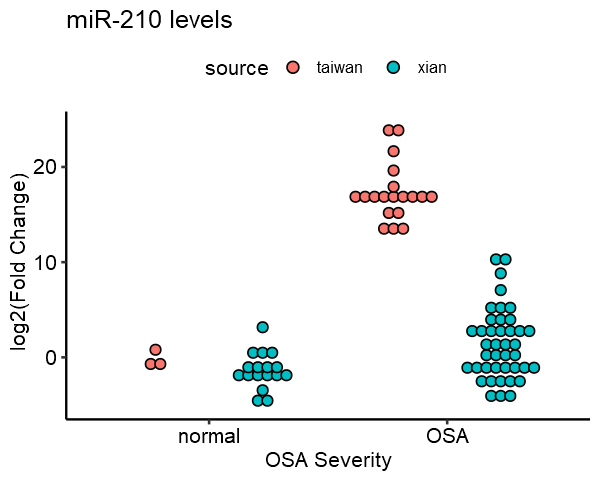

In [79]:
options(repr.plot.width=5, repr.plot.height=4)
dt_melt <- melt(dt[source == "xian" | source == "taiwan" ,], id.vars = c("log2_mir210_FC" , "source" ),measure.vars = c("severity"))
dt_melt[value == "mild" | value == "moderate" | value == "severe",]$value <- "OSA"
dt_melt$value <- factor(dt_melt$value, levels= c("normal", "OSA"),labels = c("normal", "OSA"))
suppressWarnings(dotplotgraph(dataset = dt_melt, 
                              xaxis = dt_melt$value, 
                              yaxis = dt_melt$log2_mir210_FC, 
                              xlabel = "OSA Severity",
                              ylabel = "log2(Fold Change)",
                              title = "miR-210 levels", 
                              dodge = 0.9, 
                              bin = 1.0))

#### Identify differences between the taiwan and xian datasets

In [136]:
k <- intersect(colnames(dt_sub[source == "taiwan",purrr::map_lgl(dt_sub, is.numeric), with = FALSE] %>% select_if(~sum(!is.na(.)) > 0)),
               colnames(dt_sub[source == "xian",purrr::map_lgl(dt_sub, is.numeric), with = FALSE] %>% select_if(~sum(!is.na(.)) > 0)))
continuous_compare(DT1 = dt_sub[source == "taiwan",purrr::map_lgl(dt_sub, is.numeric), with = FALSE] %>% select_if(~sum(!is.na(.)) > 0),
                   DT2 = dt_sub[source == "xian",purrr::map_lgl(dt_sub, is.numeric), with = FALSE] %>% select_if(~sum(!is.na(.)) > 0)
                   , compair = "Taiwan-Xian", key = k)

comparison,parameter,Mann_Whitney_U_p_value,significant
<chr>,<chr>,<dbl>,<chr>
Taiwan-Xian,cel_mir39_ct,1.359776e-12,TRUE
Taiwan-Xian,mir210_ct,1.049134e-02,TRUE
Taiwan-Xian,delta_ct_210,1.176505e-11,TRUE
Taiwan-Xian,mir210_FC,2.626805e-09,TRUE
Taiwan-Xian,age,1.724403e-05,TRUE
Taiwan-Xian,bmi,2.709975e-01,FALSE
Taiwan-Xian,weight,6.643710e-02,FALSE
Taiwan-Xian,height,1.172383e-01,FALSE
Taiwan-Xian,ahi,6.612001e-01,FALSE


In [134]:
#### retain only character columns
k <- intersect(colnames(dt_sub[source == "taiwan",purrr::map_lgl(dt_sub, is.character), with = FALSE] %>% select_if(~sum(!is.na(.)) > 0)),
               colnames(dt_sub[source == "xian",purrr::map_lgl(dt_sub, is.character), with = FALSE] %>% select_if(~sum(!is.na(.)) > 0)))
k <- k[2:length(k)]
categorical_compare(DT = dt_sub[,k, with = FALSE], compair = "Taiwan-Xian", compair_column = "source", keys = k)

comparison,parameter,Chai_squared_p_value,significant
<chr>,<chr>,<dbl>,<chr>
Taiwan-Xian,source,1.513441e-18,TRUE
Taiwan-Xian,sex,9.107971e-01,FALSE
Taiwan-Xian,obesity,1.347393e-01,FALSE
Taiwan-Xian,severity,1.830157e-01,FALSE
Taiwan-Xian,htn,4.046660e-03,TRUE
Taiwan-Xian,dm,1.540208e-04,TRUE
Taiwan-Xian,stroke,1.000000e+00,FALSE


Summary: these analyses indicate that miR210_FC, age, insulin, glucose, t_chol, tg, hdl, ldl, htn, and dm are all statistically significant parameters that differentiate the taiwan and Xi'an datasets. 

#### Propensity score match on source to rule it out as a confounding variable

In [ ]:
#glm.fit <-  glm(metformin_b ~ steroid_use, data = dt2, family = binomial)#glycosidase_inhibitors_a+steroid_use+
##summary(glm.fit)
#rr1 <- Match(Y = dt$outcome, Tr = dt$metformin_b, glm.fit$fitted, M=1) # M simulates the number of iterations 
#summary(rr1)
#mb <- MatchBalance(metformin_b ~ steroid_use, match.out = rr1, nboots = 1, data = dt)

In [ ]:
dt2 <- dt_sub[,c("source") := .(ifelse(source=="xian",1,0))]
dt2 <-dt2[!log2_mir210_FC == ""]
glm.fit <-  glm(source~log2_mir210_FC, data = dt2, family = binomial)#glycosidase_inhibitors_a+steroid_use+
#summary(glm.fit)
rr1 <- Match(Y = dt2$log2_mir210_FC, Tr = dt2$outcome, glm.fit$fitted, M=1) # M simulates the number of iterations 
summary(rr1)
mb <- MatchBalance(source ~ log2_mir210_FC, match.out = rr1, nboots = 1, data = dt2)

### Indentify attributes that correlate with miR210 as an approach to further define insights into the mechanistic basis for miR210 induction.

In [ ]:
options(repr.plot.width=7, repr.plot.height=7)
res2 <- rcorr(as.matrix(dt_sub[,c(13,16,18:19,21:22, 24:25, 28:38)]))#39, 46, 
corrplot(res2$r, type = "upper", order = "hclust", tl.col = "black", tl.srt = 45)

#### Identify the attributes that have a significant correlation (p<0.05) with miR210

In [ ]:
flat <- flattenCorrMatrix(res2$r, res2$P);flat <- flat[order(abs(flat$cor), decreasing = TRUE),]
fl210 <- flat[grep("mir210", flat$row, ignore.case = TRUE),]; fl210[fl210$p < 0.05,]

#### Plot correlations

In [ ]:
options(repr.plot.width=15, repr.plot.height=15)
p1 <- scatterplotgraph(dataset =dt_sub, 
                 xaxis = dt_sub$ahi, 
                 yaxis = dt_sub$log2_mir210_FC, 
                 xlabel = "ahi",
                 ylabel = "miR-210 log2(FC)",
                 title = "correlation between miR-210 log2(FC) and ahi")
p2 <- scatterplotgraph(dataset =dt_sub, 
                 xaxis = dt_sub$insulin, 
                 yaxis = dt_sub$log2_mir210_FC,
                 xlabel = "insulin",
                 ylabel = "miR-210 log2(FC)",
                 title = "correlation between miR-210 log2(FC) and insulin")
p3 <- scatterplotgraph(dataset = dt_sub, 
                 xaxis = dt_sub$age, 
                 yaxis = dt_sub$log2_mir210_FC, 
                 xlabel = "age",
                 ylabel = "miR-210 log2(FC)",
                 title = "correlation between miR-210 log2(FC) and age")
p4 <- scatterplotgraph(dataset = dt_sub, 
                 xaxis = dt_sub$hdl, 
                 yaxis = dt_sub$log2_mir210_FC, 
                 xlabel = "hdl",
                 ylabel = "miR-210 log2(FC)",
                 title = "correlation between miR-210 log2(FC) and hdl")
p5 <- scatterplotgraph(dataset = dt_sub, 
                 xaxis = dt_sub$ldl, 
                 yaxis = dt_sub$log2_mir210_FC, 
                 xlabel = "ldl",
                 ylabel = "miR-210 log2(FC)",
                 title = "correlation between miR-210 log2(FC) and ldl")
p6 <- scatterplotgraph(dataset = dt_sub, 
                 xaxis = dt_sub$tg, 
                 yaxis = dt_sub$log2_mir210_FC, 
                 xlabel = "tg",
                 ylabel = "miR-210 log2(FC)",
                 title = "correlation between miR-210 log2(FC) and tg")
p7 <- scatterplotgraph(dataset = dt_sub, 
                 xaxis = dt_sub$t_chol, 
                 yaxis = dt_sub$log2_mir210_FC, 
                 xlabel = "t_chol",
                 ylabel = "miR-210 log2(FC)",
                 title = "correlation between miR-210 log2(FC) and t_chol")
suppressWarnings(multiplot(p1,p2,p3,p4,p5,p6,p7, cols = 2))

These results confirm that the serum levels of miR210 correlate with t_chol, tg, ldl, hdl, age, insulin, and ahi.

## Analytical matching between identified clinical parameters and Transcription factor gene ontology

## RNAseq analysis of ECs treated with serum isolated from individuals with OSA or healthy individuals

#### Count the number of reads in each fastq file 

In [ ]:
# Load each fastq file
dir(path = "./data")
fastq <- list.files("./data", "*.fq.gz$"); fastq <- paste("data/", fastq, sep="")
names(fastq) <- paste("flowcell6_lane", 1:length(fastq), sep="_")
# Count the number of reads in each fastq file.  
countLines(dirPath="./data", pattern=".fq.gz$")/4

#### Download the human GFF/GTF and genome (fasta) files of interest

In [ ]:
URL <- "ftp://ftp.ensembl.org/pub/release-96/gtf/homo_sapiens/Homo_sapiens.GRCh38.96.gtf.gz"
download.file(URL, destfile = "./data/GTF.gtf.gz")
URLGEN <- "ftp://ftp.ensembl.org/pub/release-96/fasta/homo_sapiens/dna/Homo_sapiens.GRCh38.dna.primary_assembly.fa.gz"
download.file(URLGEN, destfile = "./data/genome.fa.gz")

#### Assess integrity of genome files

In [ ]:
myseq <- readDNAStringSet("./data/genome.fasta")
myseq
#### Calculate N percentage for all chromosomes 
freq <- alphabetFrequency(myseq)[,c(1:4, 15)]
freq <- data.table(freq)
per <- NULL
for(i in 1:nrow(freq)){
  per[i] <- freq[i,5, with = FALSE]/(freq[i,1, with = FALSE]+freq[i,2, with = FALSE]+freq[i,3, with = FALSE]+freq[i,4, with = FALSE]+freq[i,5, with = FALSE])
}
per <- unlist(per); freq$percentN <- per; freq$name <- names(myseq); freq[1:22,]

#### Set up sequencing file information

In [ ]:
#### Designate param path 
parampath <- paste(homedir, "/hisat2.param", sep = "")
read.delim(parampath, comment.char = "#")
#### Check targets.txt file 
targets <- read.delim("targets.txt", comment.char ="#")
targets#[1:3,]
#### Read .param file and targets.txt file into args object 
args <- systemArgs(sysma=parampath, mytargets="targets.txt")
args
modules(args); cores(args); names(args); sysargs(args)[1]; outpaths(args)[1]

#### Generate a quality report 

In [ ]:
fqlist <- seeFastq(fastq=infile1(args), batchsize=10000, klength=8)
#pdf("./results/1 fastqReport.pdf", height=18, width=4*length(fqlist))
seeFastqPlot(fqlist)#; dev.off()

#### Index reference genome 

In [ ]:
!system("hisat2-build ./data/genome.fasta ./data/genome.fasta")

#### 2 Align all FASTq files with hisat2
Use Ipython magic to execute commands on the command prompt and then pass the values back into the jupyter notebook.<br>
Includes the Generation of bam files. 

In [ ]:
bampaths <- !runCommandline(args=args, make_bam = TRUE)
#### Generate an allignment summary 
(read_statsDF <- alignStats(args=args))
writab(read_statsDF, fname = "./results/17 alignStats.xls")

#### Counting reads per Feature by Storing Annotations in TranscriptDb

In [ ]:
txdb <- makeTxDbFromGFF(file="data/GTF.gtf.gz", format = "gtf", dataSource= "ensembl", organism ="Homo sapiens")
saveDb(txdb, file="./data/GTF.sqlite")
txdb <- loadDb("./data/GTF.sqlite")
eByg <- exonsBy(txdb, by="gene")

#### Read Counting with summarizeOverlaps 

In [ ]:
txdb <- loadDb("./data/GTF.sqlite")
eByg <- exonsBy(txdb, by=c("gene"))
bfl <- BamFileList(outpaths(args), yieldSize=50000, index=character())
multicoreParam <- MulticoreParam(workers=7); register(multicoreParam)
counteByg <- bplapply(bfl, function(x) summarizeOverlaps(eByg, x, mode="Union", ignore.strand=TRUE, inter.feature=TRUE, singleEnd=TRUE)) # Note: for strand-specific RNA-Seq set 'ignore.strand=FALSE' and for PE data set 'singleEnd=FALSE'
countDFeByg <- sapply(seq(along=counteByg), function(x) assays(counteByg[[x]])$counts)
rownames(countDFeByg) <- names(rowRanges(counteByg[[1]])); colnames(countDFeByg) <- names(bfl)
rpkmDFeByg <- apply(countDFeByg, 2, function(x) returnRPKM(counts=x, ranges=eByg))
writab(countDFeByg, fname = "./results/18 countDFeByg.xls")
writab(rpkmDFeByg, fname = "./results/19 rpkmDFeByg.xls")

### DEG analysis with edgeR

In [ ]:
# countDF <- read.table("./results/18 countDFeByg.xls")
countDF <- read.table("./results/19 rpkmDFeByg.xls")
cmp <- readComp(args, format="matrix", delim="-")
edgeDF <- run_edgeR(countDF=countDF, targets=targetsin(args), cmp=cmp[[1]], independent=FALSE, mdsplot="")
writab(edgeDF, fname="./results/20 edgeRcomp.xls")
DEG_list <- filterDEGs(degDF=edgeDF, filter=c(Fold=2, FDR=10))
DEG_list <- filterDEGs(degDF=edgeDF, filter=c(Fold=2, FDR=20))

#### Obtain annotations from BioMart

In [ ]:
listMarts() # To choose BioMart database
# myMart <- useMart("ENSEMBL_MART_ENSEMBL"); listDatasets(myMart)
myMart <- useMart("ENSEMBL_MART_ENSEMBL", dataset=BioMartdataset)
# listAttributes(myMart)[1:100,] # Choose data types you want to download
# myMart <- useEnsembl(biomart = "ensembl", dataset = "hsapiens_gene_ensembl", mirror = "useast") # use if biomart sever is down.

Values <- row.names(edgeDF[1:(length(row.names(edgeDF))/2),])
go1 <- getBM(attributes=c("ensembl_gene_id", "wikigene_name", "wikigene_description", "ensembl_transcript_id", "external_gene_name",
                          "transcription_start_site", "strand"), mart=myMart, values = Values, filters = 'ensembl_gene_id') 
Values <- row.names(edgeDF[((length(row.names(edgeDF))/2) + 1):length(edgeDF),])
go1.1 <- getBM(attributes=c("ensembl_gene_id", "wikigene_name", "wikigene_description", "ensembl_transcript_id", "external_gene_name",
                            "transcription_start_site", "strand"), mart=myMart, values = Values, filters = 'ensembl_gene_id') 
go1 <- rbind(go1, go1.1)

Values <- row.names(edgeDF[1:(length(row.names(edgeDF))/2),])
go2 <- getBM(attributes=c("ensembl_gene_id", "go_id", "definition_1006")
             , mart=myMart, values = Values, filters = 'ensembl_gene_id') 
Values <- row.names(edgeDF[((length(row.names(edgeDF))/2) + 1):length(edgeDF),])
go2.1 <- getBM(attributes=c("ensembl_gene_id", "go_id", "definition_1006")
               , mart=myMart, values = Values, filters = 'ensembl_gene_id') 
go2 <- rbind(go2, go2.1)

go <- merge(go1, go2, by = "ensembl_gene_id")
go <- go[,c("ensembl_gene_id", "ensembl_transcript_id", "external_gene_name", "wikigene_name", "wikigene_description", "transcription_start_site", "strand", "go_id", "definition_1006")]

go <- go[go[,8]!="",]; go[,8] <- as.character(go[,8])
dir.create("./data/GO")
writab(go, fname="data/GO/GOannotationsBiomart_mod.txt")
writab(go, fname="./data/GO/GO BioMart annotations.xls")

#### Compile raw data, computed fold changes, and Gene Ontology information together

In [ ]:
##### Load in the dataset #########
DEdata <- fread("./results/20 edgeRcomp.xls")
setnames(DEdata, c(colnames(DEdata)), c("ensembl_gene_id",colnames(DEdata)[2:length(DEdata)]))
setkey(DEdata,ensembl_gene_id)
#### Merge with Biomart data.table
BioGO <- fread("./data/GO/GO BioMart annotations.xls", fill=TRUE)
BioGO <- BioGO[,c(1:2,4:9), with = FALSE]
DEdata1 <- merge(DEdata, BioGO, by="ensembl_gene_id")
DEdata1 <- DEdata1[!DEdata1$wikigene_name =="",]
DEdata1 <- DEdata1[!grepl("Rik", wikigene_name)]
DEdata1 <- DEdata1[complete.cases(DEdata1),]
write.table(DEdata1, file = "./results/17 edgeRGOannotation.xls", sep = "\t", quote = FALSE, row.names = FALSE)
DEdata <- DEdata1[!duplicated(DEdata1$ensembl_gene_id),]
write.table(DEdata, file = "./results/18 edgeRGOduprm.xls", sep = "\t", quote = FALSE, row.names = FALSE)
DEdata <- fread("./results/18 edgeRGOduprm.xls")
#### Load the raw data
rawdata <- fread("./results/3 countDFeByg.xls")
setnames(rawdata, c(colnames(rawdata)), c("ensembl_gene_id",colnames(rawdata)[2:length(rawdata)]))
#### Merge the raw data and calculated fold change data together
rawmerge <- merge(DEdata, rawdata, by="ensembl_gene_id")
rawmerge <- rawmerge[,c("ensembl_gene_id", "ensembl_transcript_id", "wikigene_name", "wikigene_description",  
                        colnames(rawmerge)[!(colnames(rawmerge) %in% c("ensembl_gene_id", "ensembl_transcript_id", 
                                                                       "wikigene_name", "wikigene_description", 
                                                                       "transcription_start_site", "strand", "go_id", 
                                                                       "definition_1006"))] ), with = FALSE]
writab(rawmerge, fname="./results/19 raw merge genes.xls", sep="\t")

## Motif enrichment in genes differentially regulated in ECs treated with serum isolated from individuals with OSA compared to serum isolated from healthy control individuals.

#### load genes that are significantly differentially regulated in HUVECs treated with serum isolated from people with OSA

In [ ]:
dt <- fread(osaseq)[,c(3:5,8)][`OSA-CTRL_PValue` < 0.05]

#### Obtain transcription start sites and transcript information from biomart

In [ ]:
name <- dt$wikigene_name
go <- BioMartR(value = name, 
               mart = "ENSEMBL_MART_ENSEMBL", 
               species = "hsapiens_gene_ensembl", 
               attribute = c("wikigene_name", "wikigene_description", "transcription_start_site", "chromosome_name", "strand"),
               filter_by = 'wikigene_name')
head(go, 1)
writab(go, fname = './data/GO BioMart annotations.xls')

#### Obtain promoter sequences and format into a .fasta file to perform a motif enrichment analysis on

In [ ]:
go <-fread('./data/GO BioMart annotations.xls')
TRANS_CHR <- go[!duplicated(go$wikigene_name),]
# Remove erroneous chromosome labels
CHR_Labels <- c(1:21, "X", "Y"); TRANS_CHR <- TRANS_CHR[(TRANS_CHR$chromosome_name %in% CHR_Labels),]
# Relabel chromosome designations for use with the getSeq Function.
TRANS_CHR <- ChromLabel(TRANS_CHR)
# Load available genomes 
ToLoad <- c("Hsapiens.UCSC.hg38"); GenomeLoader(ToLoad)
# return the promoter sequences for the identified transcripts from each Species
genomehum <- BSgenome.Hsapiens.UCSC.hg38
distance <- 2000
SurfTrans <- TRANS_CHR
STA <- SurfTrans$transcription_start_site - distance
END <- SurfTrans$transcription_start_site + distance
CHR <- SurfTrans$chromosome_name
seqs <- getSeq(genomehum, CHR, start = STA, end = END)
#### write fasta file ####
write.fasta(do.call(c, seqs), names = names(seqs), file.out = "./data/OSA_significant.fasta", open = "w", nbchar = 4001, as.string = FALSE)

#### Perform Motif discovery with BCRANK

In [ ]:
set.seed(0)
BCRANKout <- bcrank("./data/OSA_significant.fasta", restarts = 25, use.P1 = TRUE, use.P2 = TRUE)
toptable(BCRANKout)
motiftable <- data.table(toptable(BCRANKout))
write.table(motiftable, file = "./results/14 identified motifs.xls", quote=FALSE, row.names=FALSE, col.names=TRUE, sep="\t")

In [ ]:
#### graph top motif ####
topMotif <- toptable(BCRANKout, 1)
# weightMatrix <- pwm(topMotif, normalize = FALSE)
weightMatrixNormalized <- pwm(topMotif, normalize = TRUE)
seqLogo(weightMatrixNormalized)
#### save seq logos ####
#dir.create("./results/motifs")
for(i in 1:nrow(toptable(BCRANKout))){
  topMotif <- toptable(BCRANKout, i)
  # weightMatrix <- pwm(topMotif, normalize = FALSE)
  weightMatrixNormalized <- pwm(topMotif, normalize = TRUE)
  pdf(paste0("./results/motifs/seqlogo", i, ".pdf", collapse = ""))
  seqLogo(weightMatrixNormalized)
  dev.off()
}

#### Reformat identified motifs into a JASPAR format and save as .JASPAR files to integrate into python libraries

In [ ]:
dir.create("./results/JASPAR_motifs")
Organ <- "Homo_Sapiens"
for(i in 1:nrow(toptable(BCRANKout))){
  topMotif <- toptable(BCRANKout, i)
  weightMatrix <- pwm(topMotif, normalize = FALSE)
  
  BASEID <- paste("TR", i, sep="")
  name <- paste("ID_MOTIF", i, sep="")
  CLASS <- "unknown"
  fname <- paste("./results/JASPAR_motifs/ID_MOTIF", i, sep="")
  
  PARAM <-
    list(
      INT_ID=NULL,
      BASE_ID=BASEID,
      #COLLECTION="CORE",
      VERSION=1,
      NAME=name,
      SPECIES=Organ)
  TAG <-
    list(
      class=CLASS,
      medline="7592839",
      tax_group="vertebrate",
      sysgroup="vertebrate",
      acc="P30561",
      acc="P53762"#,
      #comment="dimer",
      #type="SELEX",
      #newest=1
    )
  cat(make_template(x=weightMatrix,PARAM=PARAM,TAG=TAG, outFpre = fname))
}

#### Open python libraries and match identified motifs to transcription factor motifs.

In [ ]:
MOTIF_files <- JASPAR_matrix_import(directory="./results/JASPAR_motifs")

In [ ]:
temp_df <- motifannot(jspmotifdb = "./data/JASPAR2020_CORE_vertebrates_non-redundant_pfms_jaspar", 
                      jspmotifdbopen = "./data/JASPAR2020_CORE_vertebrates_non-redundant_pfms_jaspar/", 
                      MOTIF_files = MOTIF_files, 
                      motif_dir = "./results/JASPAR_motifs/")
temp_df[grep("SRE", temp_df$comparison_name),]
writab(temp_df, fname = './results/15 motif matches.xls')

In [ ]:
temp_df <- revcompmotifannot(jspmotifdb = "./data/JASPAR2020_CORE_vertebrates_non-redundant_pfms_jaspar", 
                             jspmotifdbopen = "./data/JASPAR2020_CORE_vertebrates_non-redundant_pfms_jaspar/", 
                             MOTIF_files = MOTIF_files, 
                             motif_dir = "./results/JASPAR_motifs/")
temp_df[grep("SRE", temp_df$comparison_name),]
writab(temp_df, fname = './results/16 revcomp motif matches.xls')

## miR210 promoter transcription factor enrichment and analysis of chromatin remodeling.
This analysis uses HiF1a CHiPseq data (GEOXXXXXX) and SREBP2 overexpression ATACseq data (GEOXXXXX) collected from HUVECs that I previously analyzed and integrates it with the ENCODE database of epigenetic modification in histones in the genomic locations flanking the miR210 promoter. 

# Identify the location of SREBP2 binding sites in the miR210 promoter

#### Format miR genomic location information

miR transcription start site information was obtained from: http://mirstart.mbc.nctu.edu.tw/browse.php

In [ ]:
miDT <- fread("./data/2018-1-19 miRstart miRNA transcription start sites.csv")
setnames(miDT, colnames(miDT), c("ID",  "Accession",  "Genomic location", "Type", "TSS", "Cluster"))
#### split the Genomic location into three columns ####
GL <- miDT$`Genomic location`
GL <- gsub(":", "", GL, fixed = TRUE)
GL <- gsub("[", "", GL, fixed = TRUE)
GL <- gsub("]", "", GL, fixed = TRUE)
chromosome_name <- NULL
transcription_start_site <- NULL
Strand <- NULL
for(i in 1: length(GL)){
  spl <- strsplit(GL[i], split = " ")
  chromosome_name[i] <- spl[[1]][1]
  transcription_start_site[i] <- spl[[1]][2]
  Strand[i] <- spl[[1]][3]
}
miDT <- cbind(miDT, data.table(chromosome_name, transcription_start_site, Strand))
#### adjust data.table to download sequence data
miDT$Scientific_Name <- "Homo_sapiens"
miDT$transcription_start_site <- as.numeric(miDT$transcription_start_site)
miDT$chromosome_name <- gsub("Chr", "chr", miDT$chromosome_name, fixed = TRUE)

#### Download the miR210 promoter sequence

In [ ]:
miDT <- miDT[grepl("mir-210", miDT$ID, ignore.case = TRUE),] # subset out miR-210
ToLoad <- c("Hsapiens.UCSC.hg38"); GenomeLoader(ToLoad) # Load available genomes
genome <- c("Hsapiens.UCSC.hg38")
PROMTrans <- ChromosomeSeqCompileR(DT = miDT, Spec = genome, distance = 2000) # return the promoter sequences for the identified transcripts from each Species
setnames(PROMTrans, colnames(PROMTrans), c("ID",  "Accession",  "Genomic location", "Type", "TSS", "Cluster", "chromosome_name",  "transcription_start_site", "Strand", "Scientific_Name", "Sequence"))
PROMTrans <- SequenceSiftR(PROMTrans, Percent = 0.50, output = "return_remove")# Remove sequences that contain a large number of N's
PROMTrans[,c(1, 3:10, 12), with = FALSE]
#writab(PROMTrans, fname="./results/17 miR210 TSS DNA sequences.xls")

#### Load and annotate a data table housing transcription factor binding site information

In [ ]:
setwd("C:/Users/breng/Dropbox/Brendan Documents/programming/scripts/transcription factor consensus sequence")
TXDT <- fread("2019-3-22 TX factor data table for R BG.csv", header = TRUE); setwd(homedir)
TXDT <- TXDT[,.(prot, `MotifMap Degenerate consensus sequence`)]
TXDT$prot <- toupper(TXDT$prot)
TXDT$Consensus_Sequence_Medium <- IUPAC_Boolean(TXDT$`MotifMap Degenerate consensus sequence`, stringency = "medium")
setnames(TXDT, c("prot", "MotifMap Degenerate consensus sequence", "Consensus_Sequence_Medium"),
          c("Targeting_Factor", "MotifMap Degenerate consensus sequence", "Consensus_Sequence"))
head(TXDT, 1)

#### Identify transcription factor binding sites in the miR210 promoter

In [ ]:
setnames(PROMTrans, c("ID", "Accession", "Genomic location",  "Type", "TSS", "Cluster", "chromosome_name", "transcription_start_site", "Strand", "Scientific_Name", "Sequence", "Percent_N"),
                    c("gene_symbol", "Accession", "Genomic location","Type", "TSS", "Cluster", "chromosome_name", "transcription_start_site", "Strand", "Scientific_Name", "Sequence", "Percent_N"))
PROMTrans$Common_Name <- "Human"
TX_TOT_Species <- TFpredict(Target = PROMTrans, Targeting_Factor_DT = TXDT, type = "multiple_species")
#writab(TX_TOT_Species, fname="./results/18 Raw Transcription factor hits.xls")

In [ ]:
sre <-TX_TOT_Species[Targeting_Factor == "SREBF2"][,c(2:3,9, 5), with = FALSE]#
sre[,position := (2000 - start)];sre

#### Compute and plot binding site abundance

In [ ]:
TX_ABUN <- TFRankR(DT = TX_TOT_Species, sortBy = "abundance", dec = TRUE)
TX_ABUN <- TX_ABUN[TX_ABUN$Species == "Human",]
TX_ABUN  <- TX_ABUN[!duplicated(TX_ABUN$Targeting_Factor),]
TX_ABUN <- TX_ABUN[TX_ABUN$Number_Hits > 9,]
#### cross reference to hypoxia data and replot 
hypoxia <- fread("./data/15 hypoxia raw merge genes.xls")
TX_ABUN <- TX_ABUN[(TX_ABUN$Targeting_Factor %in% hypoxia$wikigene_name),]

g1 <- ggplot(TX_ABUN,
             aes(y=Number_Hits, x=reorder(`Targeting_Factor`,-Number_Hits), ymin=0, ymax=Number_Hits), col="blue") +
  geom_point(size=.9, color="grey") +
  geom_point(data = subset(TX_ABUN, Targeting_Factor == "SREBF2"),
             aes(x=reorder(`Targeting_Factor`, -Number_Hits), y=Number_Hits),
             shape = 21, size = 3, colour = "black", fill ="#CB181D" )+xlab("transcript")+ylab("Number of binding sites")+
 theme(plot.title = element_text(size = 10,colour="black"))+
 theme(axis.text=element_text(size=rel(0.5)),axis.title=element_text(size=rel(0.6)))+
  theme_pubr() +
  theme(axis.text.x = element_text(angle = 90, hjust = 1))
g1
#TX_ABUN

#### Return the miR210 promoter with the closest SREBP2 binding site upstream of the transcroption start site.

In [ ]:
TX_TOT_Species[Targeting_Factor == "SREBF2" & start == 2300,] $Sequence

# KEGG pathway analysis

#### obtain NCBI information

In [ ]:
rawmerge <- fread("./data/19 OSA RNAseq raw merge genes.xls")
go <- BioMartR(value = rawmerge$ensembl_gene_id, 
               mart = "ENSEMBL_MART_ENSEMBL", 
               species = "hsapiens_gene_ensembl", 
               attribute = c("ensembl_gene_id", "entrezgene_id"),
               filter_by = 'ensembl_gene_id')
head(go, 1)

#### Categorize and rank all KEGG pathways 

In [ ]:
#### format data ####
pathway <- merge(go, rawmerge,  by = "ensembl_gene_id")[,c(2,11:18)]
pathnames <- pathway$entrezgene_id
pathway <- as.matrix(pathway[,2:9])
rownames(pathway) <- pathnames 
#### set up comparison information
cn <- colnames(pathway)
hn <- grep('Z',cn, ignore.case =TRUE)
dcis <- grep('OSA',cn, ignore.case =TRUE)
#### run analysis on canonical signaling and metabolic pathways
data(kegg.gs)
pathway.kegg.p <- gage(pathway, gsets = kegg.gs, ref = hn, samp = dcis)
pathway.d <- gagePrep(pathway, ref = hn, samp = dcis)
#### print out upregulated pathways
sel <- pathway.kegg.p$greater[, "p.val"] < 0.1 & !is.na(pathway.kegg.p$greater[, "p.val"])
path.ids <- rownames(pathway.kegg.p$greater)[sel]
path.ids2 <- substr(path.ids, 1, 8)
#dir.create("./results/pathway_analysis/up")
#setwd("./results/pathway_analysis/up")
#pv.out.list <- sapply(path.ids2, function(pid) pathview(gene.data = pathway.d[,1:2], pathway.id = pid, species = "hsa"))
#setwd(homedir)
#### print out downregulated pathways
sel <- pathway.kegg.p$greater[, "p.val"] < 0.1 & !is.na(pathway.kegg.p$greater[, "p.val"])
path.ids <- rownames(pathway.kegg.p$less)[sel]
path.ids2 <- substr(path.ids, 1, 8)
#dir.create("./results/pathway_analysis/down")
#setwd("./results/pathway_analysis/down")
#pv.out.list <- sapply(path.ids2, function(pid) pathview(gene.data = pathway.d[,1:2], pathway.id = pid, species = "hsa"))
#setwd(homedir)

#### Generate a plot of the overall signifigance of each canonical signaling/metabolic pathway 

In [ ]:
options(repr.plot.width=7, repr.plot.height=7)
#### upregulated pathways
rnames <- rownames(pathway.kegg.p$greater)
great <- data.table(pathway.kegg.p$greater)
great$pathname <- rnames
great <- great[,c(3,10)][complete.cases(great),]
great$direction <- "upregulated"
#### downregulated pathways
rnames <- rownames(pathway.kegg.p$less)
less <- data.table(pathway.kegg.p$less)
less$pathname <- rnames
less <- less[,c(3,10)][complete.cases(less),]
less$direction <- "downregulated"
#### compined pathways
sigpathways <- rbind(great, less)
sigpathways$logp <- -log10(sigpathways$p.val)
#### subset significant pathways 
sigpathways <- sigpathways[sigpathways$p.val < 0.05]
#### Generate plot ####
p <- ggplot(sigpathways, aes(x= reorder(`pathname`, -`logp`), y= `logp`)) + 
  geom_point(shape = 21, size = 4, colour = "black", fill = "gray") + 
  theme_pubr() +
  labs(x = "enriched pathways", y = "-log10(p-value)") +
  ggtitle("enriched pathways (p < 0.05)")+
  theme(axis.text.x = element_text(angle = 90, hjust = 1))+
  geom_point(data = subset(sigpathways, direction == "upregulated"),
             aes(x=reorder(`pathname`, -`logp`), y=`logp`),
             shape = 21, size = 4, colour = "black", fill = "#E31A1C") +
  geom_point(data = subset(sigpathways, direction == "downregulated"),
             aes(x=reorder(`pathname`, -`logp`), y=`logp`),
             shape = 21, size = 4, colour = "black", fill = "#08519C");p

#### Plot pathways of interest

In [ ]:
sigpathwaysint <- sigpathways[grepl("Focal", sigpathways$pathname) | 
                                grepl("Leukocyte", sigpathways$pathname) | 
                                grepl("ECM", sigpathways$pathname) |
                                grepl("Cardiac", sigpathways$pathname) | 
                                grepl("TGF", sigpathways$pathname) | 
                                grepl("Oxidative", sigpathways$pathname) | 
                                grepl("Cell cycle", sigpathways$pathname) | 
                                grepl("Complement", sigpathways$pathname),]
#### Generate plot ####
p <- ggplot(sigpathwaysint, aes(x= reorder(`pathname`, -`logp`), y= `logp`)) + 
  geom_point(shape = 21, size = 4, colour = "black", fill = "gray") + 
  theme_pubr() +
  labs(x = "enriched pathways", y = "-log10(p-value)") +
  ggtitle("enriched pathways (p < 0.05)")+
  theme(axis.text.x = element_text(angle = 90, hjust = 1))+
  geom_point(data = subset(sigpathwaysint, direction == "upregulated"),
             aes(x=reorder(`pathname`, -`logp`), y=`logp`),
             shape = 21, size = 4, colour = "black", fill = "#E31A1C") +
  geom_point(data = subset(sigpathwaysint, direction == "downregulated"),
             aes(x=reorder(`pathname`, -`logp`), y=`logp`),
             shape = 21, size = 4, colour = "black", fill = "#08519C");p

#### Plot specific KEGG pathways

In [ ]:
options(warn=1)
#### format data ####
pathway <- merge(go, rawmerge,  by = "ensembl_gene_id")[,c(2,6)]
pathnames <- pathway$entrezgene_id
pathway <- matrix(pathway[,2])
rownames(pathway) <- pathnames 
#### plot pathway analysis ####
pv.out <- pathview(gene.data = pathway[, 1], pathway.id = "00190", species = "hsa", out.suffix = "gse16873")
display_png(file="hsa00190.gse16873.png") 

# Predict miR210 targets involved in mitochondrial function

#### Identify genes that are differentially regulated by OSA serum related to mitochondrial function
The gene ontology annotations were obtained by querying biomart for GO terms and definitions for genes housed in the RNAseq data from HUVECs treated with serum isolated from people with OSA compared to healthy controls. 

In [ ]:
dt <- fread("./data/17 edgeRGOannotation.xls")
dt <- dt[,c(1,2,5,8,9,12,13)]
#### subset genes that have a p-value less than 0.05
dtsig <- dt[dt$`OSA-CTRL_PValue` < 0.05,]
nrow(dtsig[!duplicated(dtsig$ensembl_gene_id),])
#### subset out genes involved in mitochondrial function
mito <- dtsig[grepl("mitochondria", dtsig$definition_1006, ignore.case = TRUE),]
mitoduprm <- mito[!duplicated(mito$ensembl_gene_id),]
#### remove erroneously identified genes
mitoduprm <- mitoduprm[!grepl("ribo", mitoduprm$definition_1006, ignore.case = TRUE),]
mitoduprm <- mitoduprm[!grepl("nerve", mitoduprm$definition_1006, ignore.case = TRUE),]
mitoduprm <- mitoduprm[!grepl("release of cytochrome c", mitoduprm$definition_1006, ignore.case = TRUE),]
mitoduprm <- mitoduprm[!grepl("brown adipocyte", mitoduprm$definition_1006, ignore.case = TRUE),]
mitoduprm <- mitoduprm[!grepl("movement of cytochrome c from the mitochondrial", mitoduprm$definition_1006, ignore.case = TRUE),]
mitoduprm <- mitoduprm[!grepl(" programmed necrotic cell death", mitoduprm$definition_1006, ignore.case = TRUE),]
#### add KEGG pathway genes
one <- dt[grepl("NADH dehydrogenase", dt$wikigene_description, ignore.case = TRUE),]
two <- dt[grepl("NDUFS", dt$wikigene_name, ignore.case = TRUE),]
three <- dt[grepl("NDUFA", dt$wikigene_name, ignore.case = TRUE),]
four <- dt[grepl("NDUFB", dt$wikigene_name, ignore.case = TRUE),]
five <- dt[grepl("COX", dt$wikigene_name, ignore.case = TRUE),]
six <- dt[grepl("ATP synthase", dt$wikigene_description, ignore.case = TRUE),]
mitoduprm <- rbind (one, two, three, four, five, six, mitoduprm)
mitoduprm <- mitoduprm[!duplicated(mitoduprm$ensembl_gene_id),]
head(mitoduprm, 1)
#writab(mitoduprm, fname="./results/47.1 mitochondrial genes.xls")

#### Get mRNA sequences for identified transcripts

In [ ]:
#### Load the sequence compiled mRNA database
setwd("C:/Users/breng/Dropbox/Brendan Documents/programming/bioinformatics/cDNA_transcriptome/2016-3-6 cDNA transcriptomes") # Windows
mRNAs <- fread("3 Annotated species mRNA compilation.xls")
setwd(homedir)
mRNAs$external_gene_name <- toupper(mRNAs$external_gene_name)
#### Return mRNAs for DEGs identified
mitoduprmless <- mitoduprm[mitoduprm$`OSA-CTRL_logFC` < 0,]
ID2 <- toupper(mitoduprmless$wikigene_name)
TRANS_CHR <- mRNAs[(mRNAs$external_gene_name %in% ID2),]
TRANS_CHR <- TRANS_CHR[order(TRANS_CHR$external_gene_name),]
#### Remove erroneous chromosome labels
CHR_Labels <- c(1:21, "X", "Y")
TRANS_CHR <- TRANS_CHR[(TRANS_CHR$chromosome_name %in% CHR_Labels),]
#### Relabel chromosome designations for use with the getSeq Function.
TRANS_CHR <- ChromLabel(TRANS_CHR)
#### Sort out Splice Variants so that the longest transcript of each protein is represented only once in each species 
setnames(TRANS_CHR, c("ensembl_transcript_id", "Sequence", "Species_File", "Scientific_Name", "Common_Name", "external_gene_name", "transcription_start_site", "transcript_start", "transcript_end", "chromosome_name"),
         c("ensembl_transcript_id", "Sequence", "Species_File", "Scientific_Name", "Common_Name", "external_gene_name", "transcription_start_site", "transcript_start", "transcript_end", "chromosome_name"))
PROMTrans <- VariantSort(TRANS_CHR, variant = "MAX")
PROMTrans[1,c(1, 3:11), with = FALSE]
#writab(PROMTrans, fname="./data/mito Longest Variant Transcripts.xls")

#### load and format miRNA sequences 

In [ ]:
setwd("C:/Users/breng/Dropbox/Brendan Documents/programming/bioinformatics/miRNA_transcriptome/2018-3-16 miRNA sequences") # Windows
MatMiRNA <- fread("unqueried MiRNA data table.xls")
setwd(homedir)
MatMiRNA <- MatMiRNA[MatMiRNA$miRNA_type == "MATURE",]
#### Reformat the table to include the species 
MiRNADT <- MatMiRNA; MiRNADT <- MiRNASpeciesAnnot(MiRNADT)
#### remove the species designation from the miRNA name and add it to another column
MiRNADT <- MiRNAname(MiRNADT)
#### Determine miRNA seed sequence (positions 2-8 from the 5' end). Must be perfectly complimentary for miRNA binding to mRNA 
MiRNADT <- MISeed(MiRNADT)
#### identify the miRNA query sequence 
MiRNADT <- MIQuerySeq(MiRNADT, wobble = TRUE)
#### subset miR-210
MiRNADT <- MiRNADT[grepl("mir-210", MiRNADT$miRNA, ignore.case = TRUE),];MiRNADT

#### Query miRNA's against mRNA sequences to identify what mRNA sequences contain a miR SEED sequence

In [ ]:
PROMTransmRNA <- PROMTrans
setnames(PROMTransmRNA, colnames(PROMTransmRNA),
         c("ensembl_transcript_id", "Sequence", "Species_File", "Scientific_Name", "Species", "external_gene_name", "transcription_start_site", "transcript_start", "transcript_end", "chromosome_name", "Length"))
setnames(MiRNADT, c("Sequence", "miRNA_Name", "miRNA_type", "Common_Name", "Scientific_Name", "seed_Sequence", "Query_Sequence"),
         c("Sequence", "miRNA_Name", "miRNA_type", "Species", "Scientific_Name", "seed_Sequence", "Query_Sequence"))
Spec <- c("Homo_sapiens", "Mus_musculus", "Rattus_norvegicus")
MiRNAhitstot <- MIRNATargetpredict(MiRNADT = MiRNADT, mRNADT = PROMTransmRNA, type = "Multiple", Spe = Spec)
#### remove the species designation from the miRNA name and add it to another column in the new dataset 
MiRNAhitstot <- MiRNAname(MiRNAhitstot) 
#### Retain only miRNA mRNA association conservation between HMR for each mRNA
setnames(MiRNAhitstot, c("Query_Sequence", "start", "end", "miRNA_Name", "mRNA_Name", "Number_Hits", "length", "Sequence", "Species", "miRNA"),
         c("Query_Sequence", "start", "end", "miRNA_Name", "gene_symbol", "Number_Hits", "length", "Sequence", "Species", "Targeting_Factor"))
MiRNAhitstot <- SpeciesTFCons(DT = MiRNAhitstot,Spec = c("Homo_sapiens", "Mus_musculus", "Rattus_norvegicus"), provide = "TF_Target")
#write.table(MiRNAhitstot, file = "./results/49 miR210 target hits HMR conserved.xls", sep="\t", quote=FALSE, row.names=FALSE)
#### Annotate identified putative miR-210 targets with food changes
#mitoduprm 
miR210targ <- MiRNAhitstot#<- fread("./results/49 miR210 target hits HMR conserved.xls")
mitoduprm$miRtarget <- "not miR210 target"
mitoduprm[(mitoduprm$wikigene_name %in% miR210targ$gene_symbol),]$miRtarget <- "miR210 target"
head(mitoduprm,1)
#write.table(mitoduprm, file = "./results/50 FC annotated miR210 targets.xls", sep="\t", quote=FALSE, row.names=FALSE)

#### Generate a heatmap of genes involved in mitochondrial function

In [ ]:
options(repr.plot.width=7, repr.plot.height=19)
mitoduprmsub <- mitoduprm[,c(1:4,8)]
rawmerge <- fread(osaseq)
RPKM <- fread("./data/4 OSA rpkmDFeByg.xls")
setnames(RPKM, colnames(RPKM), c("ensembl_gene_id", "RPKM_OSA_1",  "RPKM_OSA_2",  "RPKM_OSA_3",  "RPKM_OSA_4",  "RPKM_Z_1",  "RPKM_Z_2",  "RPKM_Z_3", "RPKM_Z_4"))
RPKMmer <- merge(rawmerge, RPKM, by = "ensembl_gene_id")
RPKMmito <- RPKMmer[(RPKMmer$ensembl_gene_id %in% mitoduprmsub$ensembl_gene_id),]
#### format data ####
DATA <- RPKMmito[,c(3, 18:25)]
DATA <- as.data.frame(DATA)
#### normalize data to difference from fow means ####
DAT <- DATA[,2:9]
means <- rowMeans(DAT)
table <- data.table()
for(i in 1:length(means)){
  norm <- as.numeric(DAT[i,])/means[i]
  dt <- t(data.table(norm))
  rownames(dt) <- i
  dt <- data.table(dt)
  table <- rbind(table, dt)
}
setnames(table, colnames(table), c("RPKM_OSA_1", "RPKM_OSA_2", "RPKM_OSA_3", "RPKM_OSA_4", "RPKM_Z_1", "RPKM_Z_2", "RPKM_Z_3", "RPKM_Z_4"))
table <- as.data.frame(table)
row.names(table) <- DATA$wikigene_name

DATA_matrix <- data.matrix(table)
p <- pheatmap(DATA_matrix,
              cellwidth = 10,
              cellheight = 8,
              cluster_row = TRUE,
              cluster_cols = TRUE
);p

#### Make heatmap of only downregulated genes annotated with target of miR-210 

In [ ]:
options(repr.plot.width=7, repr.plot.height=9)
mitoduprmsub <- mitoduprm[,c(1:4,8)]
mitoduprmsub <- mitoduprmsub[mitoduprmsub$`OSA-CTRL_PValue` < 0.05,]
mitoduprmsubless <- mitoduprmsub[mitoduprmsub$`OSA-CTRL_logFC` < 0,]
rawmerge <- fread(osaseq)
RPKM <- fread("./data/4 OSA rpkmDFeByg.xls")
setnames(RPKM, colnames(RPKM), c("ensembl_gene_id", "RPKM_OSA_1",  "RPKM_OSA_2",  "RPKM_OSA_3",  "RPKM_OSA_4",  "RPKM_Z_1",  "RPKM_Z_2",  "RPKM_Z_3", "RPKM_Z_4"))
RPKMmer <- merge(rawmerge, RPKM, by = "ensembl_gene_id")
RPKMmito <- RPKMmer[(RPKMmer$ensembl_gene_id %in% mitoduprmsubless$ensembl_gene_id),]
RPKMmito <- merge(RPKMmito, mitoduprmsubless[,c(1,5)], by = "ensembl_gene_id")
RPKMmito <- RPKMmito[order(RPKMmito$miRtarget),]
#### format data ####
DATA <- RPKMmito[,c(3, 18:25)]
DATA <- as.data.frame(DATA)
#### normalize data to difference from fow means ####
DAT <- DATA[,2:9]
means <- rowMeans(DAT)
table <- data.table()
for(i in 1:length(means)){
  norm <- as.numeric(DAT[i,])/means[i]
  dt <- t(data.table(norm))
  rownames(dt) <- i
  dt <- data.table(dt)
  table <- rbind(table, dt)
}
setnames(table, colnames(table), c("RPKM_OSA_1", "RPKM_OSA_2", "RPKM_OSA_3", "RPKM_OSA_4", "RPKM_Z_1", "RPKM_Z_2", "RPKM_Z_3", "RPKM_Z_4"))
table <- as.data.frame(table)
row.names(table) <- DATA$wikigene_name
DATA_matrix <- data.matrix(table)

annotation_row = data.frame(
  miR210target = factor(RPKMmito$miRtarget)
)
rownames(annotation_row) = RPKMmito$wikigene_name

p <- pheatmap(DATA_matrix,
              cellwidth = 10,
              cellheight = 8,
              cluster_row = FALSE,
              cluster_cols = FALSE,
              gaps_row=c(31),
              annotation_row = annotation_row
);p

#### End of analysis